## Author Classifier for News Articles

In this notebook we will build a news article author classifier. We will create our model using a random sample of the "All the News" kaggle dataset with 143,000 articles from 15 American publications and thousands of authors.

#### The general outline of the notebook is as follows:

1. Read-in and preprocess data:<br>
    a. Look for analysis sample based on article length and number of articles<br>
    b. Randomly sample articles from several authors<br>
2. Clean data:<br>
    a. Remove punctuation<br>
    b. Lemmatize<br>
    c. Label encoding<br>
    d. Split and Term Frequency Inverse Document Frequency vectorization<br>
3. Analysis:<br>
    a. Run chi-2 test to check for unigrams and bi-grams most strongly correlated with author labels<br>
    b. Run dimension reductionality techniques (PCA, TSNE, and LDA) on data and plot<br>
    c. Run several baseline models/pipelines<br>
    d. Tune hyperparameters for best candidates models with grid search<br>

In [89]:
# general
import pickle
import pandas as pd
import re
import numpy as np
import warnings

# viz
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

# options
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [90]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
# import seaborn as sns
# import nltk
# sns.set_style("whitegrid")
# # import altair as alt
# # alt.renderers.enable("notebook")

# # Code for hiding seaborn warnings
# import warnings
# warnings.filterwarnings("ignore")
# pd.options.display.max_rows = 4000

# df_path = "/home/lnc/0. Latest News Classifier/01. Dataset Creation/"

Read in raw data and concatenate

In [91]:
df_path = 'data/'
df_temp1 = pd.read_csv(df_path + 'articles1.csv')
df_temp2 = pd.read_csv(df_path + 'articles2.csv')
df_temp3 = pd.read_csv(df_path + 'articles3.csv')

In [92]:
df_temp = df_temp1.append(df_temp2).append(df_temp3)

In [93]:
df_temp.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


Won't need most of this data so we will drop some columns and create a content length column below

In [94]:
df_raw = df_temp.set_index('id')[['title','publication', 'year', 'content', 'author']]
df_raw['content_len'] = df_raw['content'].apply(len)
df_raw.shape

(142570, 6)

In [95]:
pd.options.display.max_rows = 4000

## EDA and sample selection

Our next goal will be to limit the sample of articles to a dataset of only a few authors so we can build a straight forward classifier for only a few authors. The authors we select will depend on the number of articles and character length of those articles; we want to pick authors that have many articles of reasonable length. 

Let's look at the distribution of article's character lengths

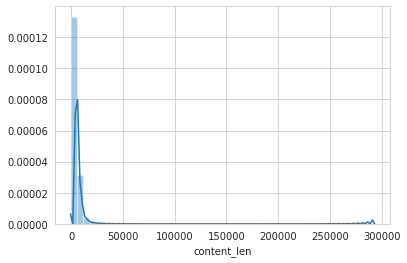

In [96]:
# sns.distplot(df.loc[df.content_len.between(0, 20000),'content_len'], bins=50)
sns.distplot(df_raw.loc[:, 'content_len'], bins=50)
plt.show()

Our distribution is positively skewed, let's remove some of the outliers

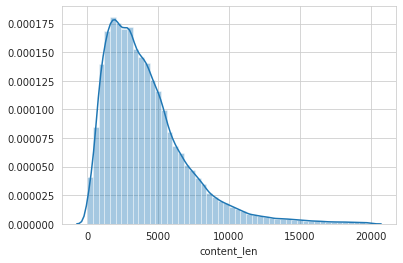

In [97]:
sns.distplot(df_raw.loc[df_raw.content_len.between(0, 20000), 'content_len'], bins=50)
plt.show()

example of a 2000 character article

In [98]:
df_raw.loc[df_raw['content_len'].between(2000, 20000)].sort_values(by = 'content_len').iloc[1,3]

'Painting the town red this weekend?   beat you to it: She just turned a Hurricane   building in Fort Tilden, Queens, sunset rouge, making it look like a giant urban Rothko. “I wanted to make something that totally transforms the house,” says the German artist of “Rockaway! ,” the   installation commissioned by MoMA PS1. “So I wanted a color that is artificial and strange in that area. ” Though she worked for three months on architectural models back home in Berlin, she came to the abandoned military base only a week ago. “The scale surprised me,” she says of Fort Tilden. “The space was so large and vast, with the beach and sky and water, and the house with the tree next to it. I started seeing it more like a landscape painting. ” She ended up   not just the structure but the surrounding vegetation and concrete. She says the color, and the way it bleeds into the surrounding landscape, adds life and vitality to the ghostlike shack. “That’s the power of painting,” she says. “It can take 

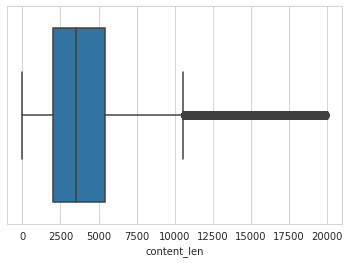

In [99]:
sns.boxplot(x=df_raw.loc[df_raw['content_len'].between(0, 20000), 'content_len'])
plt.show()

Based on plots above, it looks like half our data has character length between ~2000 and ~6000. This range should be a good target for the articles we want in our sample. Let's look at the counts of articles in this range by author.

In [100]:
df_raw.loc[df_raw['content_len'].between(2000, 6000), ['author', 'publication']].groupby(['author', 'publication']).size().sort_values(ascending = False)[:10]

author            publication  
Associated Press  New York Post    547
Daniel Nussbaum   Breitbart        495
Joel B. Pollak    Breitbart        490
Camila Domonoske  NPR              465
Jerome Hudson     Breitbart        436
John Hayward      Breitbart        434
Merrit Kennedy    NPR              419
NPR Staff         NPR              349
Breitbart News    Breitbart        337
Frances Martel    Breitbart        328
dtype: int64

Probably won't want to take the authors like "Associate Press", "NPR Staff", and "Breitbart News", but we will put these names in a list and plot the counts

In [101]:
candidate_authors = df_raw.loc[df_raw['content_len'].between(2000, 6000)].groupby('author').size().sort_values(ascending = False)[:10].index

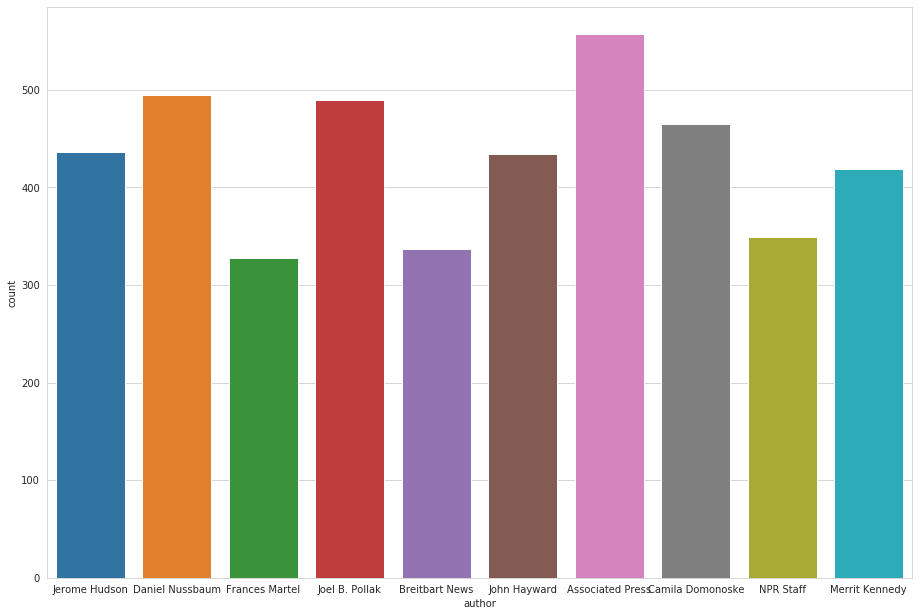

In [102]:
fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
sns.countplot(x="author", data=df_raw.loc[df_raw['content_len'].between(2000, 6000) & df_raw['author'].isin(candidate_authors)])
plt.show()

'Camila Domonoske','Joel B. Pollak','Daniel Nussbaum','Jerome Hudson', and 'John Hayward' are looking like good candidates because they all have over 400 articles, let's set these as our new candidates and compare the character length means and standard deviations before making a decision.

In [103]:
candidate_authors = ['Camila Domonoske', 'Joel B. Pollak', 'Daniel Nussbaum', 'Jerome Hudson', 'John Hayward']

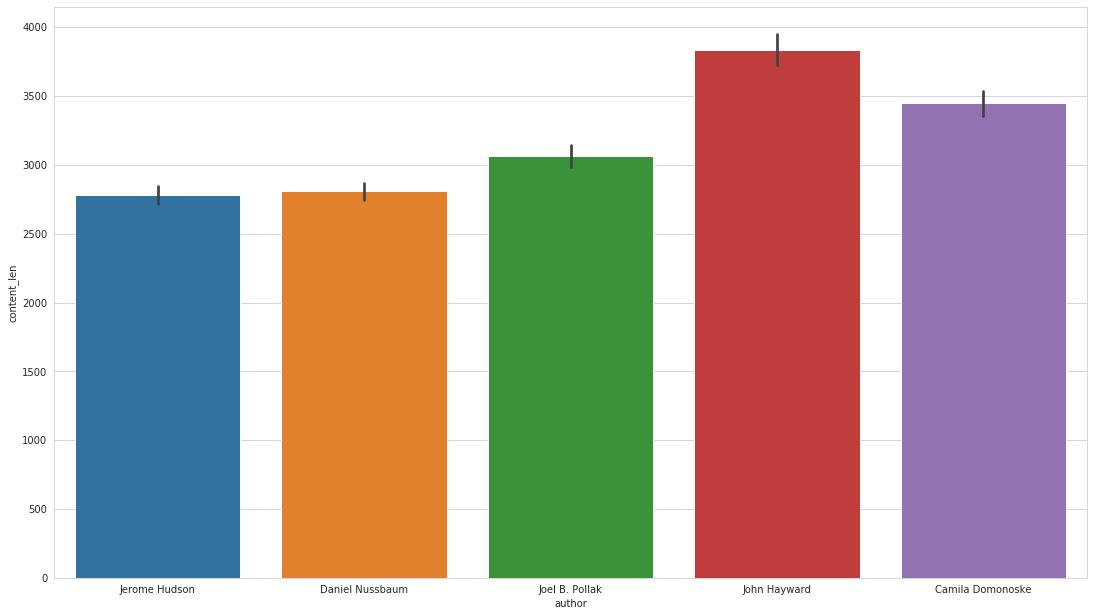

In [104]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.barplot(x="author", y="content_len", data=df_raw.loc[df_raw['content_len'].between(2000, 6000) & df_raw['author'].isin(candidate_authors)])
plt.show()

'John Hayward' seems to write longer articles than the other candidate authors and I don't want the model to predict based on length (don't ask me why), so let's drop him from our authors and move forward building a classifier for the four authors assigned below.

In [105]:
authors = ['Camila Domonoske','Joel B. Pollak','Daniel Nussbaum','Jerome Hudson']

Let's take one last look at the count and character length descriptive stats for our four authors.

In [106]:
df_raw.loc[df_raw['content_len'].between(2000, 6000) & df_raw['author'].isin(authors), ['content_len','author']].groupby('author').agg(['size', 'mean', 'median', 'std']).sort_values(by=('content_len','size'), ascending = False)

content_len                                 
                        size         mean  median         std
author                                                       
Daniel Nussbaum          495  2807.224242  2601.0  728.287740
Joel B. Pollak           490  3065.269388  2774.5  970.137420
Camila Domonoske         465  3448.670968  3270.0  970.735229
Jerome Hudson            436  2781.520642  2573.5  755.580627

We have at least 400 articles for each of our authors and the mean, median, and std character length of our articles are in a tight range, ensuring the consistency of the articles we are comparing and hopefully driving our classifier to be built on the contentof the articles.

In [107]:
# subset data authors and range described above
df_2 = df_raw.loc[df_raw['content_len'].between(2000, 6000) & df_raw['author'].isin(authors)]

In [108]:
df_2.head()

,title,publication,year,content,author,content_len
id,,,,,,
26551,James Cameron Slams Trump’s Administration: ‘T...,Breitbart,2017.0,Film director and climate change activist Jame...,Jerome Hudson,2500
26567,Jerry Seinfeld: I Don’t Get the ’Big Deal’ Abo...,Breitbart,2017.0,Jerry Seinfeld has lent his support to Kathy G...,Daniel Nussbaum,2060
26570,Watch: Celebrities Narrate Animated History of...,Breitbart,2017.0,"As a Republican, administration prepares to ...",Daniel Nussbaum,2584
26585,Miss USA Walks Back Health Care Position after...,Breitbart,2017.0,Miss USA Kara McCullough is walking back an ...,Jerome Hudson,2479
26593,Irvine Unveils Memorial to Honor Fallen Heroes...,Breitbart,2017.0,Gold Star families gathered in the Southern Ca...,Joel B. Pollak,2330


In [109]:
# ranomly sample 400 articles from each author
df_analysis_samp = df_2.groupby('author').apply(lambda x: x.sample(400)).reset_index(drop = True)
df_analysis_samp.shape

(1600, 6)

Take a peek at new dataset

In [110]:
df_analysis_samp.to_csv('df_analysis_samp.csv')

### Clean data for NLP

In [111]:
df = df_analysis_samp.copy()

In [112]:
df.head()

,title,publication,year,content,author,content_len
0,Centuries-Old Flea Market In France Canceled T...,NPR,2016.0,"For centuries, the northern French town of Lil...",Camila Domonoske,3714
1,’Sheer Terror’ As Attack Along French Riviera ...,NPR,2016.0,"At a beachside restaurant in Nice, France, Eri...",Camila Domonoske,5652
2,Here’s Why Mississippi’s ’Religious Freedom’ B...,NPR,2016.0,"This week, Mississippi lawmakers approved a bi...",Camila Domonoske,5108
3,"After Surviving Aegean Sea, Syrian Swimmer Hop...",NPR,2016.0,"Last summer, Yusra Mardini was swimming throug...",Camila Domonoske,2730
4,Officials Close Investigation Into 1964 ’Missi...,NPR,2016.0,Mississippi officials are closing the investig...,Camila Domonoske,3882


In [113]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let's do some general data cleaning before Lemmatization

In [114]:
# concat article and title
df['content_full'] = df['title'] + ' ' + df['content']
# make all lowercase
df['content_cleaned_2'] = df['content_full'].str.lower()

In [115]:
df['content_cleaned_3'] = df['content_cleaned_2']  
# remove punctuation
punctuation_signs = list("?:!.,;…“”'’\"")
for punct_sign in punctuation_signs:
    df['content_cleaned_3'] = df['content_cleaned_3'].str.replace(punct_sign, '')

### Lemmatization

[Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) usually refers to removing inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

In [116]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [117]:
nrows = len(df)
lemmatized_text_list = []

for row in range(nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['content_cleaned_3']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [118]:
df['content_cleaned_4'] = lemmatized_text_list

Next we will get a general list of stop words to remove. Stop words are common words (e.g. the, at, I, etc) that add little predictive power in nlp modeling. 

Note: We will also be removing some other words that would be dead giveaways for our model, since our goal is to predict that author based on the content/tendencies of the author's writing. We would find these giveaway stop words with a chi-squared test later on, but I retroactively removed them to give a linear flow to this notebook

In [119]:
%%capture
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
# Loading the stop words in english
stop_words = [*list(stopwords.words('english')), 
              *list(map(lambda x: x.split(' ')[0].lower(), df['author'].unique())), # taking out authors names
              *['nussbaum', 'hudson', 'jeromeehudson', 'dznussbaum', 'breitbart', # take out words for generalizability
                'pollak', 'joelpollak', 'regnery', 'senior', 'news', 'twitter', 'https', 
                '2017', '19']]

In [121]:
df['content_cleaned_5'] = df['content_cleaned_4']
# remove stop words
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['content_cleaned_5'] = df['content_cleaned_5'].str.replace(regex_stopword, '')

In [122]:
df['content_cleaned_6'] = df['content_cleaned_5']
# remove strange spaces
df['content_cleaned_6'] = df['content_cleaned_6'].apply(lambda x: re.sub("\s\s+", " ", x))

In [123]:
# rename cleaned content feature
df = df.rename(columns={'content_cleaned_6': 'content_cleaned'})

Limit dataframe to cleaned content and author

In [124]:
list_columns = ["author", 
                "content_cleaned"]
df_clean = df[list_columns]
df_clean.head()

,author,content_cleaned
0,Camila Domonoske,centuries-old flea market france cancel year t...
1,Camila Domonoske,sheer terror attack along french riviera kill ...
2,Camila Domonoske,heres mississippis religious freedom bill cont...
3,Camila Domonoske,survive aegean sea syrian swimmer hop spot ol...
4,Camila Domonoske,officials close investigation 1964 mississippi...


## Analysis prep

#### Label encoding

In [125]:
category_codes = {
    'Camila Domonoske': 0,
    'Daniel Nussbaum': 1,
    'Jerome Hudson': 2,
    'Joel B. Pollak': 3}

In [126]:
# Category mapping
df_clean['Category_Code'] = df_clean['author']
df_final = df_clean.replace({'Category_Code':category_codes})

Split our data into train and test sets

In [127]:
X_train, X_test, y_train, y_test = train_test_split(df_final['content_cleaned'], 
                                                    df_final['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

#### TFID Vectorization

We are going to encode our data using [Term Frequency – Inverse Document](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

>Term Frequency: This summarizes how often a given word appears within a document.

>Inverse Document Frequency: This downscales words that appear a lot across documents.

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.


In [128]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [129]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1360, 300)
(240, 300)


#### Chi-squared test for dependence 

Below we'll run a chi-squared test to find the unigrams and bigrams with the highest dependence with the labels

In [130]:
for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])), "\n")

# 'Camila Domonoske' category:
  . Most correlated unigrams:
. press
. trump
. clinton
. associate
. report
  . Most correlated bigrams:
. hillary clinton
. donald trump 

# 'Daniel Nussbaum' category:
  . Most correlated unigrams:
. reportedly
. star
. hollywood
. actor
. film
  . Most correlated bigrams:
. white house
. new book 

# 'Jerome Hudson' category:
  . Most correlated unigrams:
. available
. black
. foundation
. social
. pic
  . Most correlated bigrams:
. new book
. social media 

# 'Joel B. Pollak' category:
  . Most correlated unigrams:
. democrats
. obama
. hard
. book
. available
  . Most correlated bigrams:
. social media
. new book 



### Dimension reduction analysis

Nect, we will run [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), and [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) on our data to see if it improves separability of classes or adds predictive power.

In [158]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

In [159]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)

In [160]:
def plot_dim_red(model, features, labels, n_components):

    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
    elif (model == 'TSNE'):
        mod = TSNE(n_components=n_components)
        title = "t-SNE decomposition" 
    elif (model == 'LDA'):
        mod = LinearDiscriminantAnalysis(n_components=n_components)
        title = "LDA decomposition" 
    else:
        return "Error"
    
    # Fit and transform features based on model
    if (model != 'LDA'):
        principal_components = mod.fit_transform(features)
    else:
        principal_components = mod.fit(features, labels).transform(features)
        
    # Create Principal Component's dataframe 
    if n_components == 2:
        df_features = pd.DataFrame(data=principal_components,
                         columns=['PC1', 'PC2'])
    elif n_components == 3:
        df_features = pd.DataFrame(data=principal_components,
                         columns=['PC1', 'PC2', 'PC3'])
    
    
    # Concat features and labels for plotting
    df_labels = pd.DataFrame(data=labels,
                             columns=['label_name'])
    df_full = pd.concat([df_features, df_labels], axis=1)

    # Plot 2 components
    if n_components == 2:
        plt.figure(figsize=(10,10))
        sns.scatterplot(x='PC1',
                        y='PC2',
                        hue="label_name", 
                        data=df_full,
                        palette=["red", "pink", "royalblue", "greenyellow"],
                        alpha=.7).set_title(title)
    
    # Plot 3 components
    if n_components == 3:
        df_full['label_name'] = df_full['label_name'].apply(lambda x: int(x))
        fig = go.Figure(data=[go.Scatter3d(x=df_full['PC1'], y=df_full['PC2'], z=df_full['PC3'], 
                                           marker=dict(size=3, color=df_full['label_name'], opacity=0.8), mode='markers')])
        fig.show()

PCA with two principal components below separates classes 0 and 3 but not 1 and 2

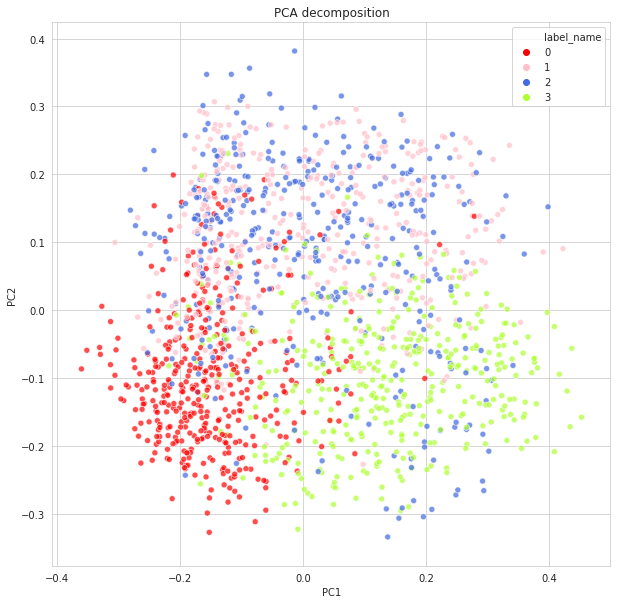

In [161]:
plot_dim_red("PCA", 
             features=features, 
             labels=labels,
             n_components=2)
plt.show()

TSNE with two principal components below slightly separates classes 0 and 3 but not 1 and 2

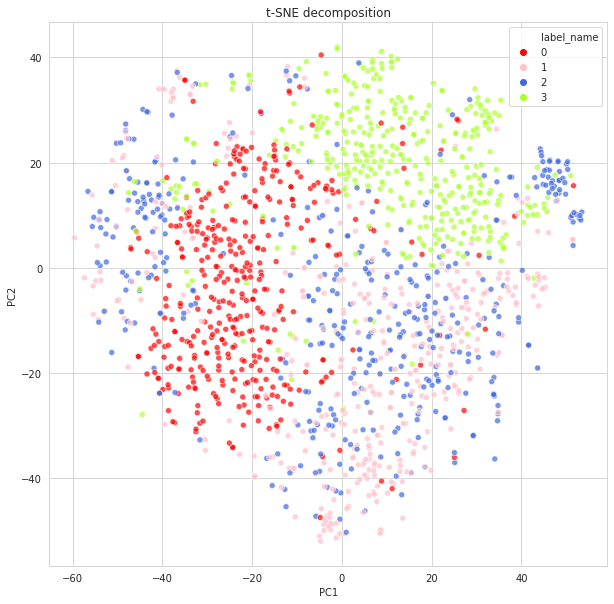

In [163]:
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components=2)
plt.show()

LDA with two principal components below separates classes 0 and 3 very well but not 1 and 2--let's see if a third component will improve the separability

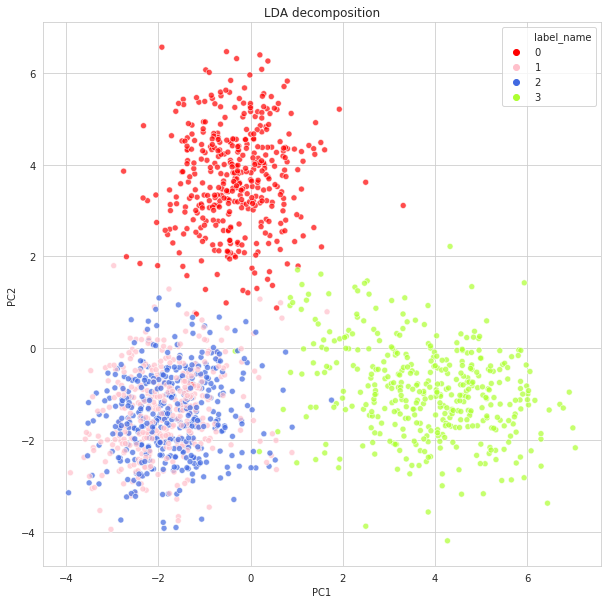

In [165]:
plot_dim_red("LDA", 
             features=features, 
             labels=labels,
             n_components=2)
plt.show()

In [138]:
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components = 3)

As expected, LDA with three principal components separates our classes very well. I expect this algorithm to acheive good results.

In [167]:
plot_dim_red("LDA", 
             features=features, 
             labels=labels,
             n_components = 3)

We can also see below that we need almost all of our components to explain the variance in our dataset, therefore dimension reduction might not be so successful or necessary.

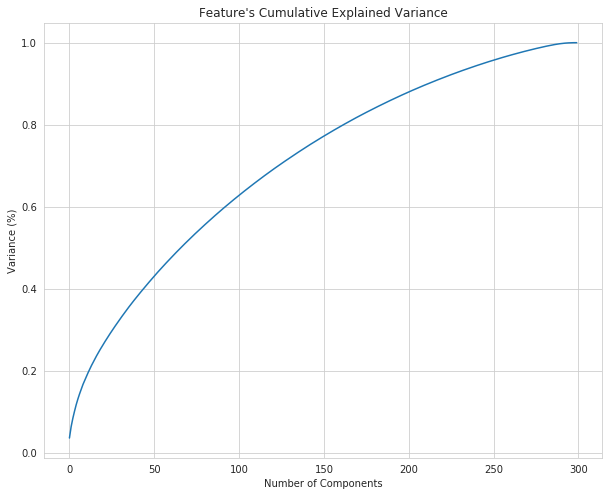

In [176]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(features)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize = (10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Feature\'s Cumulative Explained Variance')
plt.show()

## Modeling

Now we'll write a test harness to compare several basline models with a 5 fold croxx validation. Then we'll move forward with hyperparameter tuning on pipelines including scalers and our most successful models.

In [177]:
# models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

#scale
from sklearn.preprocessing import RobustScaler, StandardScaler

#general
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

In [178]:
num_folds = 5
seed = 7
scoring = 'accuracy'

# create models
pipelines = []
pipelines.append(('ET', ExtraTreesClassifier()))
pipelines.append(('LDA', LinearDiscriminantAnalysis()))
pipelines.append(('RFC', RandomForestClassifier()))
pipelines.append(('LR', LogisticRegression()))
pipelines.append(('XGB', XGBClassifier()))
pipelines.append(('KNN', KNeighborsClassifier()))
pipelines.append(('DT', DecisionTreeClassifier()))

# make pipelines with scalers for each model
# scalers = [('Scaler', StandardScaler()), ('RobustScaler', RobustScaler())]

# models=[('ET', ExtraTreesClassifier()),
#         ('LDA', LinearDiscriminantAnalysis()),
#         ('LR', LogisticRegression()),
#         ('XGB', XGBClassifier()),
#         ('KNN', KNeighborsClassifier()),
#         ('DT', DecisionTreeClassifier()),
#         ('GBM', GradientBoostingClassifier())]

# for scaler in scalers:
#     for model in models:
#         pipelines.append(('{}_{}_{}'.format(scaler[0], model[0]), Pipeline([scaler, model])))
        
# run all pipelines        
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, features_train, labels_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ET: 0.710294 (0.014595)
LDA: 0.812500 (0.024052)
RFC: 0.729412 (0.030192)
LR: 0.807353 (0.017338)
XGB: 0.808824 (0.025258)
KNN: 0.731618 (0.014706)
DT: 0.680882 (0.020849)


In [179]:
df_results = pd.DataFrame(np.array(results).T, columns = names)

Text(0, 0.5, 'accurary')

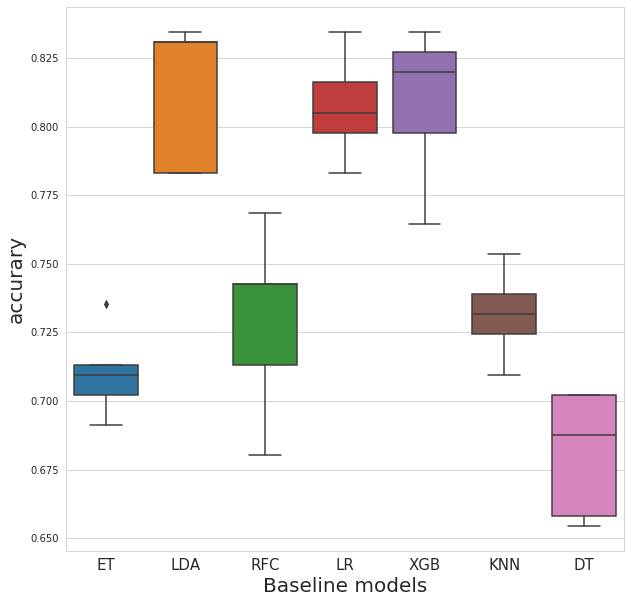

In [180]:
fig, ax = plt.subplots(figsize=(10,10))
fig = sns.boxplot(data=df_results)
fig = fig.set_xticklabels(labels = df_results.columns,fontdict={'fontsize':15})
ax.set_xlabel('Baseline models', size = 20)
ax.set_ylabel('accurary', size = 20)

Next we attempt to improve our performance with hyperparameter tuning on LR and XGB; LDA has a closed-form solution and therefore has no hyperparameters.

In [182]:
param_grid = {'penalty' : ['l1', 'l2'], 'C' : np.linspace(1, 5, 10)}
grid = GridSearchCV(estimator = LogisticRegression(),
                    param_grid = param_grid, 
                    scoring = 'accuracy', 
                    cv = 10, 
                    n_jobs = -1)
# %%capture
grid_result = grid.fit(features_train, labels_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

Best: 0.830882 using {'C': 3.6666666666666665, 'penalty': 'l1'}


In [183]:
param_grid = {'max_depth': [4,6,8,10], 'n_estimators': [100,200,250,300]}
grid = GridSearchCV(estimator = XGBClassifier(),
                    param_grid = param_grid, 
                    scoring = 'accuracy', 
                    cv = 10, 
                    n_jobs = -1)
# %%capture
grid_result = grid.fit(features_train, labels_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

Best: 0.831618 using {'max_depth': 6, 'n_estimators': 100}


In [156]:
import time
def forest_test(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
    print(time.process_time() - start)
    predictionforest = trainedforest.predict(X_Test)
    print(confusion_matrix(Y_Test,predictionforest))
    print(classification_report(Y_Test,predictionforest))

In [157]:
forest_test(X_ae,labels_train)

1.6114945040000066
[[68 15 14  8]
 [29 40 16 17]
 [24 28 22 26]
 [ 7  9 13 72]]
              precision    recall  f1-score   support

           0       0.53      0.65      0.58       105
           1       0.43      0.39      0.41       102
           2       0.34      0.22      0.27       100
           3       0.59      0.71      0.64       101

    accuracy                           0.50       408
   macro avg       0.47      0.49      0.48       408
weighted avg       0.47      0.50      0.48       408



In [ ]:
feats = pd.DataFrame(features_train)

In [ ]:
labels = pd.Series(labels_train, column = 'labels')

In [ ]:
corrmat = pd.DataFrame(features_train).corr()
top_corr_features = corrmat.index[abs(labels_train)>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Notes:
Be sure to add pub name to stop words

In [ ]:
print('doddo')